#Limpieza

Se instala Kaggle

In [217]:
!pip install kaggle==1.5.12

Es necesario ubicar el archivo de autenticación de Kaggle en la dirección luego de ser cargados a la carpeta de archivos de Colab.

In [218]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Se descarga el dataset

In [219]:
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


Se descomprime el dataset

In [220]:
!unzip /content/udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Archive:  /content/udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Importación de librerías

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import unicodedata
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

Se carga el archivo de training para realizar un análisis exploratorio de datos. Debido a que el archivo es de extensión .csv se utiliza la rutina de pandas **read_csv**

In [222]:
train_dataset = pd.read_csv('/content/train.csv')

Se verifica el número total de **características** (columnas) que tiene el archivo y el número total de **registros**.

In [295]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 661643 entries, 0 to 692499
Data columns (total 67 columns):
 #   Column                                                                   Non-Null Count   Dtype   
---  ------                                                                   --------------   -----   
 0   FAMI_ESTRATOVIVIENDA                                                     661643 non-null  float64 
 1   coef_1                                                                   661643 non-null  float64 
 2   coef_2                                                                   661643 non-null  float64 
 3   coef_3                                                                   661643 non-null  float64 
 4   ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones    661643 non-null  float64 
 5   ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones  661643 non-null  float64 
 6   ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos d

In [223]:
print(f'Número total de características: {train_dataset.shape[1]}')
print(f'Número total de muestras: {train_dataset.shape[0]}')

Número total de características: 21
Número total de muestras: 692500


Se verifica cuantas columnas contienen valores faltantes para luego realizar un análisis que permita tomar decisiones de reemplazar o eliminar esos valores faltantes.

In [224]:
num_columns_with_missing_values = train_dataset.isnull().sum()[train_dataset.isnull().sum() > 0].count()
print(f"Columnas con valores faltantes: {num_columns_with_missing_values}")

Columnas con valores faltantes: 11


In [225]:
train_dataset.isnull().sum()[train_dataset.isnull().sum() > 0].sort_values(ascending=False)

,0
FAMI_TIENEAUTOMOVIL,43623
FAMI_TIENELAVADORA,39773
FAMI_TIENECOMPUTADOR,38103
FAMI_ESTRATOVIVIENDA,32137
ESTU_HORASSEMANATRABAJA,30857
FAMI_TIENEINTERNET.1,26629
FAMI_TIENEINTERNET,26629
FAMI_EDUCACIONMADRE,23664
FAMI_EDUCACIONPADRE,23178
ESTU_PAGOMATRICULAPROPIO,6498


Se realiza un resumen de los **estadísticos descriptivos** para las columnas númericas.




In [226]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,692500.0,494606.130576,285585.209455,1.0,247324.750,494564.500,741782.500,989286.000
PERIODO,692500.0,20198.366679,10.535037,20183.0,20195.000,20195.000,20203.000,20213.000
coef_1,692500.0,0.268629,0.122130,0.0,0.203,0.240,0.314,0.657
coef_2,692500.0,0.259996,0.093480,0.0,0.212,0.271,0.309,0.487
coef_3,692500.0,0.262087,0.058862,0.0,0.254,0.276,0.293,0.320
coef_4,692500.0,0.262903,0.067944,0.0,0.255,0.285,0.303,0.332


Inicialmente se eliminará la columna de **ID** y de **Periodo** debido a que únicamente corresponden a identificadores.

In [227]:
train_dataset.drop(['ID','PERIODO'], axis=1, inplace=True)

Se analizaron las variables númericas para ver las distribuciones y posibles correlaciones entre las mismas. Debido a que hay una alta correlación entre el **coef_4** con los **coef_2** y **coef_3**, se decidió eliminar el **coef_4** para evitar problemas de colinealidad en el modelo.

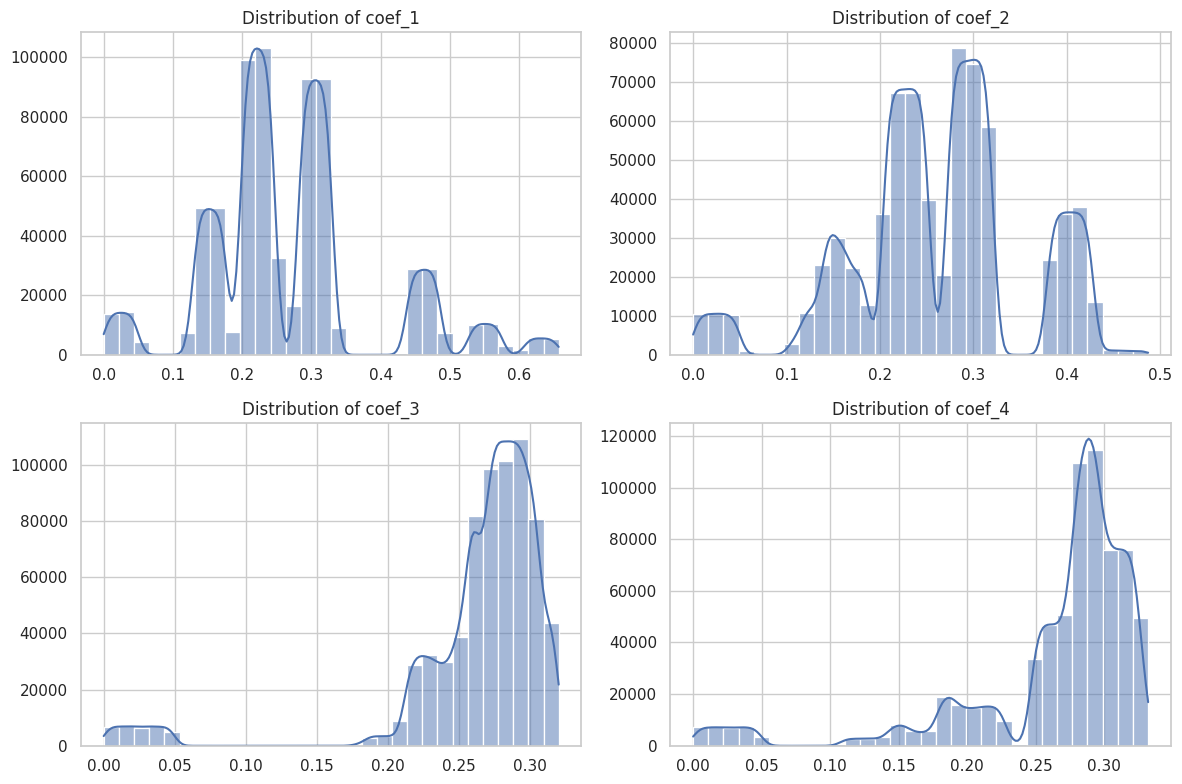

In [228]:
numerical_columns = ['coef_1', 'coef_2', 'coef_3', 'coef_4']

# Plot the distribution of numerical variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(train_dataset[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

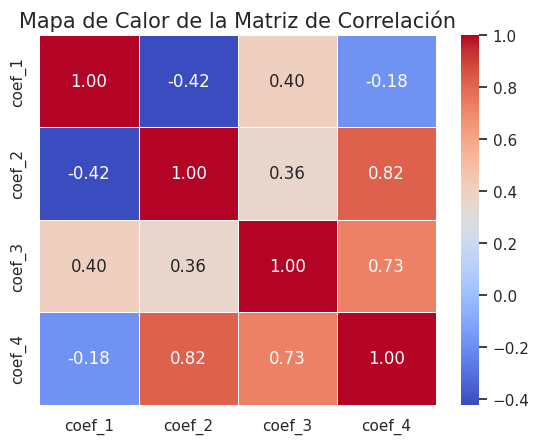

In [229]:
correlation_matrix = train_dataset[['coef_1', 'coef_2', 'coef_3', 'coef_4']].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar=True
)

plt.title('Mapa de Calor de la Matriz de Correlación', fontsize=15)
plt.show()

In [230]:
train_dataset.drop('coef_4', axis=1, inplace=True)

Se realiza un resumen de los **estadísticos descriptivos** para las columnas categóricas.


In [231]:
train_dataset.describe(include=[object,bool]).T

,count,unique,top,freq
ESTU_PRGM_ACADEMICO,692500,948,DERECHO,53244
ESTU_PRGM_DEPARTAMENTO,692500,31,BOGOTÁ,282159
ESTU_VALORMATRICULAUNIVERSIDAD,686213,8,Entre 1 millón y menos de 2.5 millones,204048
ESTU_HORASSEMANATRABAJA,661643,5,Más de 30 horas,249352
FAMI_ESTRATOVIVIENDA,660363,7,Estrato 2,232671
FAMI_TIENEINTERNET,665871,2,Si,592514
FAMI_EDUCACIONPADRE,669322,12,Secundaria (Bachillerato) completa,128289
FAMI_TIENELAVADORA,652727,2,Si,563390
FAMI_TIENEAUTOMOVIL,648877,2,No,412606
ESTU_PRIVADO_LIBERTAD,692500,2,N,692466


Debido a que en este caso nuestro target es el **rendimiento global** realizamos un resumen de cuantas muestras pertenecen a cada una de las categorías. En este caso, será una clasificación multiclase con clases apróximadamente balanceadas.

In [232]:
train_dataset['RENDIMIENTO_GLOBAL'].value_counts()

,count
RENDIMIENTO_GLOBAL,
alto,175619
bajo,172987
medio-bajo,172275
medio-alto,171619


##FAMI_ESTRATOVIVIENDA

En general, se visualizó el estrato de la vivienda del estudiante separado por su rendimiento en las pruebas. Paa estratos superiores al 3, siempre se tiene que la mayoría de personas obtuvo un resultado alto en las pruebas. Para estratos inferiores o personas sin estrato, el grupo predominante son aquellos que obtuviero resultados bajos o medio bajos. En este caso los valores faltantes se imputarán sin estrato.

In [233]:
train_dataset[train_dataset['FAMI_ESTRATOVIVIENDA'].isna()].shape

(32137, 18)

In [234]:
train_dataset['FAMI_ESTRATOVIVIENDA'] = train_dataset['FAMI_ESTRATOVIVIENDA'].fillna('Sin Estrato')

<ipython-input-235-50e30c1ce60e>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['FAMI_ESTRATOVIVIENDA', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


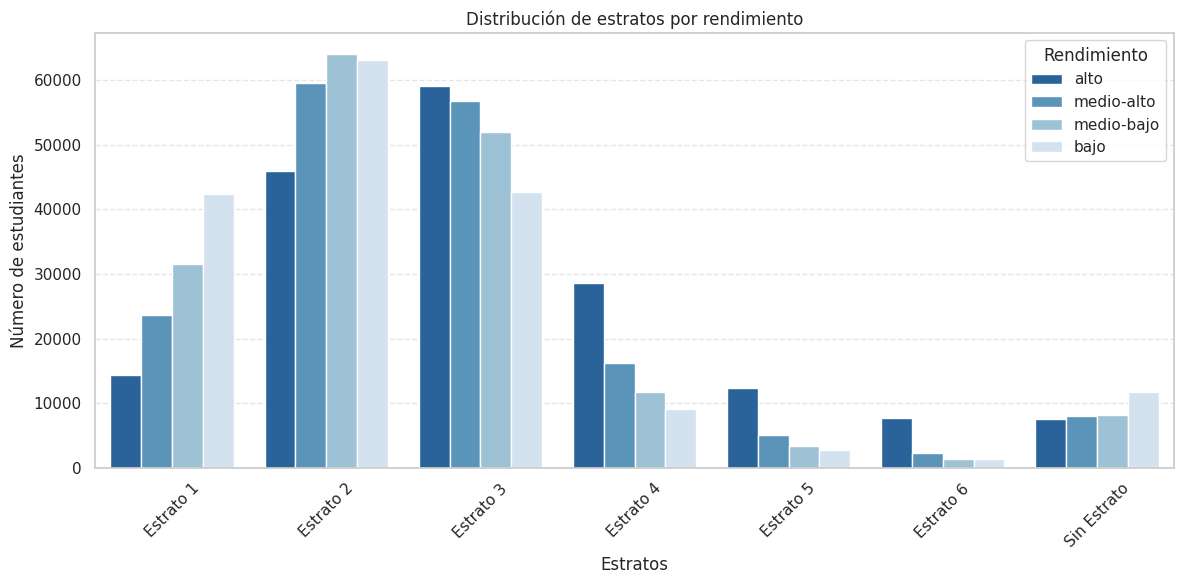

In [235]:
orden_rendimiento = [
    'alto',
    'medio-alto',
    'medio-bajo',
    'bajo'
]

train_dataset['RENDIMIENTO_GLOBAL'] = pd.Categorical(
    train_dataset['RENDIMIENTO_GLOBAL'],
    categories=orden_rendimiento,
    ordered=True
)

grouped = train_dataset.groupby(['FAMI_ESTRATOVIVIENDA', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='FAMI_ESTRATOVIVIENDA',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de estratos por rendimiento')
plt.xlabel('Estratos')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

##ESTU_VALORMATRICULAUNIVERSIDAD

Adicionalmente, se visualizó la distribución del rendimiento con respecto a al valor de la matrícula y se revisaron los valores faltantes para esta columna.

In [236]:
train_dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = train_dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna('No aplica')

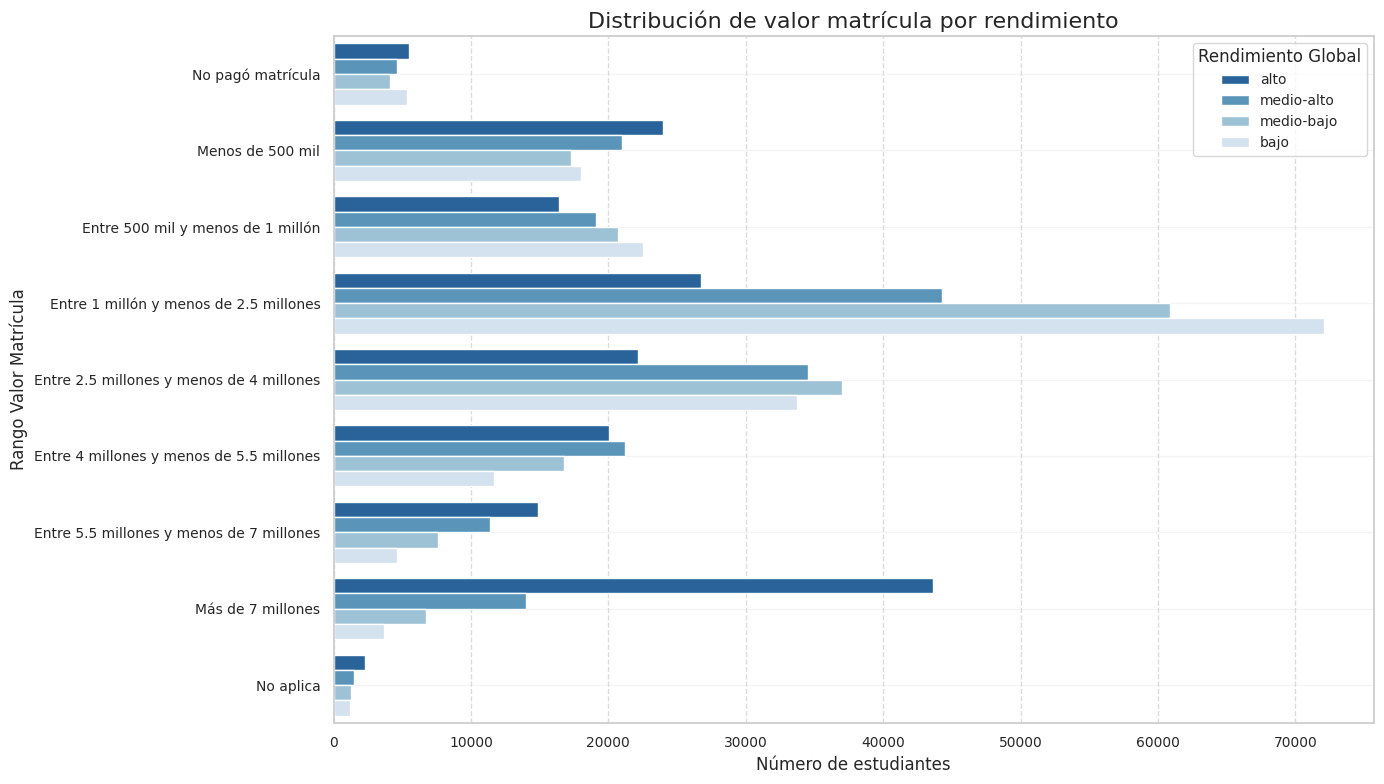

In [237]:
orden_matricula = [
    'No pagó matrícula',
    'Menos de 500 mil',
    'Entre 500 mil y menos de 1 millón',
    'Entre 1 millón y menos de 2.5 millones',
    'Entre 2.5 millones y menos de 4 millones',
    'Entre 4 millones y menos de 5.5 millones',
    'Entre 5.5 millones y menos de 7 millones',
    'Más de 7 millones',
    'No aplica'
]

orden_rendimiento = [
    'alto',
    'medio-alto',
    'medio-bajo',
    'bajo'
]

train_dataset['ESTU_VALORMATRICULAUNIVERSIDAD'] = pd.Categorical(
    train_dataset['ESTU_VALORMATRICULAUNIVERSIDAD'],
    categories=orden_matricula,
    ordered=True
)

train_dataset['RENDIMIENTO_GLOBAL'] = pd.Categorical(
    train_dataset['RENDIMIENTO_GLOBAL'],
    categories=orden_rendimiento,
    ordered=True
)

grouped = train_dataset.groupby(
    ['ESTU_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL'],
    observed=False
).size().reset_index(name='count')


# 4. Graficar
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='count',
    y='ESTU_VALORMATRICULAUNIVERSIDAD', # Seaborn respetará el orden de esta variable categórica
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de valor matrícula por rendimiento', fontsize=16)
plt.xlabel('Número de estudiantes', fontsize=12)
plt.ylabel('Rango Valor Matrícula', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.legend(title='Rendimiento Global', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [238]:
train_dataset[train_dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].isna()].shape

(0, 18)

##ESTU_PRGM_DEPARTAMENTO

Se analizó la pertenencia a un departamento buscando diferencias significativas entre departamentos. Se hizó una normalización de los nombres de los departamentos y se construyeron los mapas para cada uno de los rendimientos. Los departamentos de Vichada ni Guainia cuentan con datos en el dataset.

In [239]:
def limpiar_nombre(nombre):
    if pd.isna(nombre):
        return None

    nombre_normalizado = unicodedata.normalize('NFD', str(nombre).upper())
    nombre_limpio = "".join(c for c in nombre_normalizado if unicodedata.category(c) != 'Mn')

    # Reemplazos para estandarizar al GeoJSON

    if 'BOGOTA' in nombre_limpio:
        return 'SANTAFE DE BOGOTA D.C'

    if 'SAN ANDRES' in nombre_limpio:
        return 'ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA'

    if 'NARINO' in nombre_limpio:
        return 'NARIÑO'

    if 'VALLE' in nombre_limpio:
        return 'VALLE DEL CAUCA'

    if 'NORTE SANTANDER' in nombre_limpio:
        return 'NORTE DE SANTANDER'

    return nombre_limpio.strip()

In [240]:
train_dataset['ESTU_PRGM_DEPARTAMENTO'] = train_dataset['ESTU_PRGM_DEPARTAMENTO'].apply(limpiar_nombre)

In [241]:
RUTA_GEOJSON_COLOMBIA = '/content/colombia.geo.json'
gdf_colombia = gpd.read_file(RUTA_GEOJSON_COLOMBIA)
gdf_colombia['ubicacion_limpia_geojson'] = gdf_colombia['NOMBRE_DPT'].apply(limpiar_nombre)

In [242]:
categorias_unicas = train_dataset['RENDIMIENTO_GLOBAL'].unique()
mapas_por_categoria = {}

for categoria in categorias_unicas:

    df_categoria_actual = train_dataset[train_dataset['RENDIMIENTO_GLOBAL'] == categoria].copy()
    conteo_por_ubicacion = df_categoria_actual.groupby('ESTU_PRGM_DEPARTAMENTO').size().reset_index(name=f'conteo_{categoria}')

    gdf_mapa_categoria = gdf_colombia.merge(
        conteo_por_ubicacion,
        left_on='ubicacion_limpia_geojson',
        right_on='ESTU_PRGM_DEPARTAMENTO',
        how='left'
    )

    gdf_mapa_categoria[f'conteo_{categoria}'] = gdf_mapa_categoria[f'conteo_{categoria}'].fillna(0)
    mapas_por_categoria[categoria] = gdf_mapa_categoria

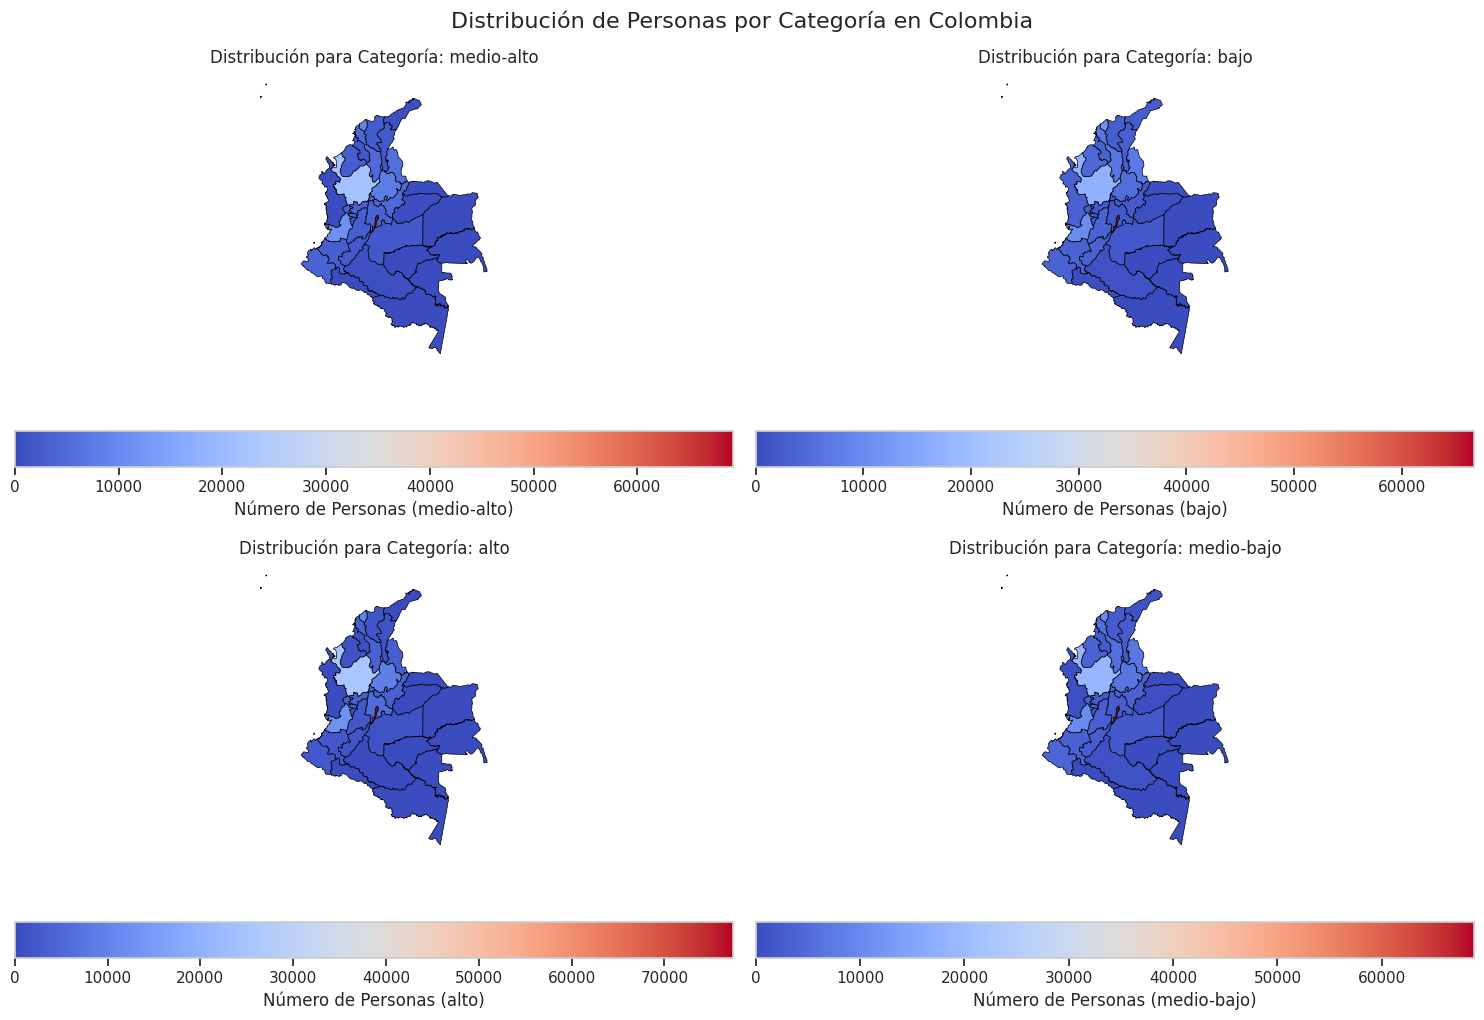

In [243]:
num_categorias = len(categorias_unicas)

cols_subplot = 2
rows_subplot = 2

fig, axes = plt.subplots(rows_subplot, cols_subplot, figsize=(15, 5 * rows_subplot))
axes = axes.flatten()

for i, categoria in enumerate(categorias_unicas):
    ax = axes[i]
    gdf_a_plotear = mapas_por_categoria[categoria]

    gdf_a_plotear.plot(
        column=f'conteo_{categoria}', # Columna con los valores a mapear
        ax=ax,
        legend=True,
        legend_kwds={'label': f"Número de Personas ({categoria})", 'orientation': "horizontal"},
        cmap='coolwarm',
        missing_kwds={
            "color": "white",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Sin datos",
        },
        edgecolor='black',
        linewidth=0.5
    )

    ax.set_title(f"Distribución para Categoría: {categoria}")
    ax.set_axis_off()


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribución de Personas por Categoría en Colombia", fontsize=16, y=1.02)
plt.show()

Debido a que la separación por departamentos no muestra diferencias debido a que la mayoría de registros vienen de Bogotá, se decidió agrupar los departamentos por regiones para simplificar la viasualización y en caso de condificación one-hot, simplificar el número de columnas generadas. Teniendo en cuenta lo anterior, se decide eliminar la columna **ESTU_PRGM_DEPARTAMENTO**.

In [244]:
mapa_departamento_a_region = {
    'AMAZONAS': 'Amazonía',
    'ANTIOQUIA': 'Andina',
    'ARAUCA': 'Orinoquía',
    'ATLANTICO': 'Caribe', # Limpiado de 'ATLÁNTICO'
    'SANTAFE DE BOGOTA D.C': 'Andina', # Nombre estandarizado para Bogotá
    'BOLIVAR': 'Caribe',    # Limpiado de 'BOLÍVAR'
    'BOYACA': 'Andina',     # Limpiado de 'BOYACÁ'
    'CALDAS': 'Andina',
    'CAQUETA': 'Amazonía',  # Limpiado de 'CAQUETÁ'
    'CASANARE': 'Orinoquía',
    'CAUCA': 'Pacífica', # Principalmente Pacífica, aunque tiene parte Andina
    'CESAR': 'Caribe',
    'CHOCO': 'Pacífica',    # Limpiado de 'CHOCÓ'
    'CORDOBA': 'Caribe',    # Limpiado de 'CÓRDOBA'
    'CUNDINAMARCA': 'Andina',
    'GUAINIA': 'Amazonía',  # Limpiado de 'GUAINÍA'
    'GUAVIARE': 'Amazonía',
    'HUILA': 'Andina',
    'LA GUAJIRA': 'Caribe',
    'MAGDALENA': 'Caribe',
    'META': 'Orinoquía',
    'NARIÑO': 'Pacífica', # Principalmente Pacífica, aunque tiene parte Andina
    'NORTE DE SANTANDER': 'Andina',
    'PUTUMAYO': 'Amazonía',
    'QUINDIO': 'Andina',    # Limpiado de 'QUINDÍO'
    'RISARALDA': 'Andina',
    'ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA': 'Insular', # Nombre estandarizado
    'SANTANDER': 'Andina',
    'SUCRE': 'Caribe',
    'TOLIMA': 'Andina',
    'VALLE DEL CAUCA': 'Pacífica',
    'VAUPES': 'Amazonía',   # Limpiado de 'VAUPÉS'
    'VICHADA': 'Orinoquía'
}


In [245]:
train_dataset['ESTU_PRGM_REGION'] = train_dataset['ESTU_PRGM_DEPARTAMENTO'].map(mapa_departamento_a_region)
train_dataset['ESTU_PRGM_REGION'].value_counts()

,count
ESTU_PRGM_REGION,
Andina,499712
Caribe,105080
Pacífica,73802
Orinoquía,10351
Amazonía,3545
Insular,10


<ipython-input-246-32a3f26b96e7>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['ESTU_PRGM_REGION', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


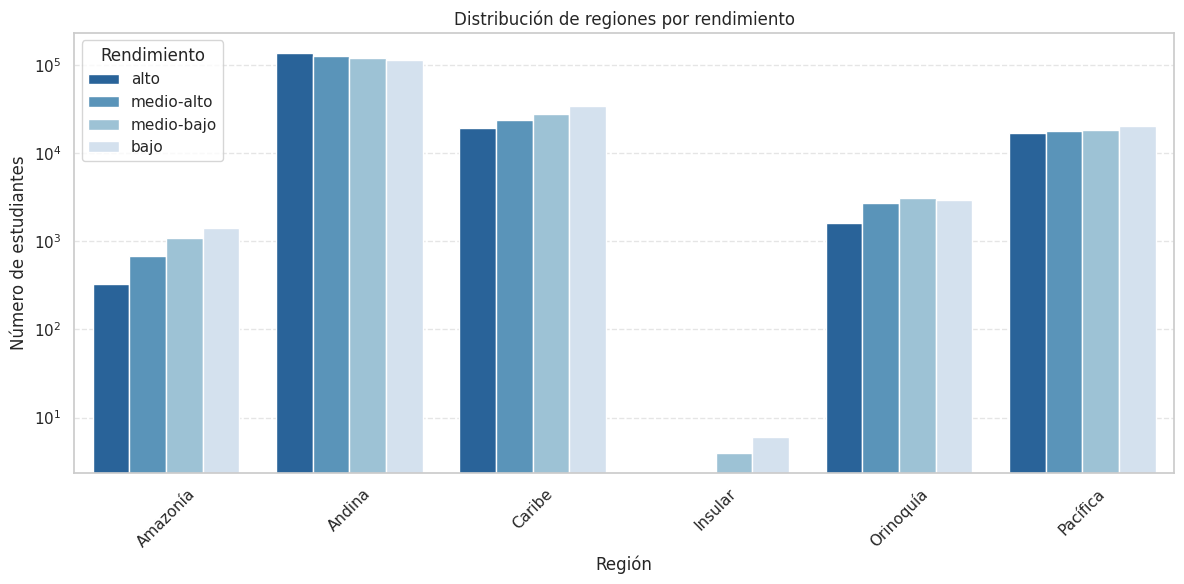

In [246]:
grouped = train_dataset.groupby(['ESTU_PRGM_REGION', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='ESTU_PRGM_REGION',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de regiones por rendimiento')
plt.xlabel('Región')
plt.ylabel('Número de estudiantes')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

In [247]:
train_dataset.drop('ESTU_PRGM_DEPARTAMENTO', inplace=True, axis=1)

##ESTU_PRGM_ACADEMICO

Los diferentes programas acádemicos se agruparon en facultades o áreas del conocimiento.

In [248]:
programas_academicos_original = train_dataset['ESTU_PRGM_ACADEMICO'].unique()

In [249]:
def normalize_text(text):

    if not isinstance(text, str):
        return ""
    try:
        text = text.upper()
        text = ''.join(c for c in unicodedata.normalize('NFD', text)
                       if unicodedata.category(c) != 'Mn')
    except Exception: # Por si acaso hay algún valor inesperado
        return ""
    return text

In [250]:
faculty_map = {
    'EDUCACION_PEDAGOGIA': ['LICENCIATURA', 'PEDAGOGIA', 'PEDAGOGÍA', 'NORMALISTA', 'ENSEÑANZA', 'DIDACTICA', 'ETNOEDUCACION'],
    'CIENCIAS_SALUD': [
        'MEDICINA', 'ENFERMERIA', 'ODONTOLOGIA', 'VETERINARIA', 'FISIOTERAPIA', 'NUTRICION', 'DIETETICA',
        'SALUD OCUPACIONAL', 'SALUD EN EL TRABAJO', 'SEGURIDAD Y SALUD EN EL TRABAJO',
        'QUIMICA FARMACEUTICA', 'FARMACIA', 'INSTRUMENTACION QUIRURGICA', 'OPTOMETRIA',
        'TERAPIA RESPIRATORIA', 'TERAPIA OCUPACIONAL', 'BACTERIOLOGIA', 'FONOAUDIOLOGIA', 'GERONTOLOGIA',
        'SALUD PUBLICA', 'BIOANALISIS', 'EPIDEMIOLOGIA', 'SALUD',
        'TERAPIAS PSICOSOCIALES', 'TERAPIA CARDIORRESPIRATORIA', 'SALUD ORAL', 'QUIRURGICA', 'FARMAC¿UTICA'
    ],
    'INGENIERIA_TECNOLOGIA': [
        'INGENIERI', 'SISTEMAS', 'SOFTWARE', 'TELECOMUNIC', 'TECNOLOGI', 'COMPUTACION', 'INFORMATICA',
        'MECANICA', 'CIVIL', 'INDUSTRIAL', 'ELECTRONICA', 'ELECTRICA', 'QUIMICA',
        'ALIMENTOS', 'PRODUCCION', 'MECATRONICA', 'BIOMEDICA', 'CONTROL', 'PROCESOS', 'AGROINDUSTRIAL',
        'MULTIMEDIA', 'SONIDO', 'PETROLEO', 'AERONAUTICA', 'NAVAL', 'TOPOGRAFIA', 'MATERIALES', 'GEOLOGICA',
        'FORESTAL', 'ELECTROMECANICA', 'TELEMATICA', 'ENERGIA', 'AGRICOLA', 'MINAS',
        'CATASTRAL', 'AUTOMATIZACION', 'PLASTICOS', 'TEXTIL', 'MANTENIMIENTO', 'BIOQUIMICA',
        'BIOTECNOLOGICA', 'OCEANOGRAFICA', 'URBANA', 'PETROQUIMICA', 'NANOTECNOLOGIA',
        'CIENCIA DE DATOS', 'INTELIGENCIA ARTIFICIAL', 'ROBOTICA', 'DESARROLLO DE SOFTWARE',
        'CONSTRUCCION', 'CIENCIAS DE LA INFORMACION Y LA DOCUMENTACION', 'INGENIER¿A', 'URBANISMO'
    ],
    'ARTES_DISENO_COM_AUDIOVISUAL': [
        'ARTE', 'ARTES', 'DISEÑO', 'DISENO', 'MUSICA', 'ARQUITECTURA', 'COMUNICACION AUDIOVISUAL', 'AUDIOVISUAL',
        'VISUAL', 'CINE', 'TELEVISION', 'FOTOGRAFIA', 'MODA', 'VESTUARIO', 'DANZA', 'TEATRO',
        'INTERIORES', 'ESCENARIOS', 'ANIMACION', 'CULINARIA', 'GASTRONOMIA', 'REALIZACION',
        'PRODUCCION MUSICAL', 'BELLAS ARTES', 'MEDIOS AUDIOVISUALES', 'COMUNICACION GRAFICA', 'GRAFICO',
        'PUBLICIDAD', 'ESCENICAS', 'PLASTICAS', 'COREOGRAFICA', 'PATRIMONIO', 'CREACION LITERARIA',
        'INTERACTIVO', 'CROSSMEDIA', 'NARRATIVAS DIGITALES', 'COMUNICACION', 'COMUNICACI¿N', 'DISE¿¿O'
    ],
    'CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES': [
        'ADMINISTRA', 'MERCADEO', 'FINANCIERA', 'CONTADURIA', 'ECONOMIA', 'NEGOCIOS', 'COMERCIO',
        'HOTELERIA', 'TURISMO', 'GESTION', 'LOGISTICA', 'FINANZAS', 'BANCARIA', 'EMPRESARIAL',
        'AUDITORIA', 'TRIBUTARIA', 'GERENCIA', 'COMERCIAL', 'ADUANAS', 'SEGUROS', 'ADMINSITRACION', 'ECONOM¿A', 'MARKETING',
        'MERCADOLOGIA', 'RELACIONES ECONOMICAS INTERNACIONALES'
    ],
    'CIENCIAS_SOCIALES_HUMANIDADES_DERECHO': [
        'DERECHO', 'JURISPRUDENCIA', 'PSICOLOGIA', 'CIENCIA POLITICA', 'POLITICA', 'COMUNICACION SOCIAL',
        'PERIODISMO', 'TRABAJO SOCIAL', 'SOCIOLOGIA', 'FILOSOFIA', 'HISTORIA', 'ANTROPOLOGIA', 'GEOGRAFIA',
        'RELACIONES INTERNACIONALES', 'ESTUDIOS LITERARIOS', 'LITERATURA', 'LINGUISTICA', 'FILOLOGIA',
        'ARCHIVISTICA', 'BIBLIOTECOLOGIA', 'TEOLOGIA', 'PLANEACION Y DESARROLLO SOCIAL', 'CRIMINALISTICA',
        'GOBIERNO', 'ESTUDIOS POLITICOS', 'DESARROLLO FAMILIAR', 'HUMANIDADES', 'LETRAS', 'SOCIOCULTURALES',
        'PAZ', 'CONFLICTO', 'DERECHOS HUMANOS', 'ESTUDIOS CULTURALES', 'COOPERACION INTERNACIONAL',
        'CIENCIAS RELIGIOSAS', 'RELACIONES PUBLICAS', 'COMUNICACION CORPORATIVA', 'ARQUEOLOGIA', 'CIENCIAS BIBLICAS',
        'DEPOR', 'LENGUAS', 'PSICÓLOGA'
    ],
    'CIENCIAS_AGROPECUARIAS_AMBIENTALES': [
        'AGRONOMIA', 'AGROPECUARIA', 'ZOOTECNIA', 'AGROFORESTAL', 'PESQUERA', 'ACUICULTURA', 'AGRONEGOCIOS',
        'AMBIENTAL', 'ECOLOGIA', 'RECURSOS NATURALES', 'DESARROLLO RURAL', 'AGROECOLOGICA', 'AGROINDUSTRIA'
    ],
    'CIENCIAS_EXACTAS_NATURALES': [
        'ESTADISTICA', 'BIOLOGIA', 'QUIMICA',
        'MATEMATICAS', 'FISICA', 'GEOLOGIA',
        'MICROBIOLOGIA', 'GEOCIENCIAS', 'ASTRONOMIA', 'OCEANOGRAFIA',
        'BIOQUIMICA', 'BIOTECNOLOGIA',
        'CIENCIAS NATURALES', 'CIENCIAS DE LA COMPUTACION',
        'ACTUARIA', 'GEOGRAFIA FISICA', 'GEOLOG¿A', 'MATEM'
    ],
    'DEFENSA_SEGURIDAD': [
        'CIENCIAS MILITARES', 'CIENCIAS NAVALES', 'ADMINISTRACION POLICIAL', 'INVESTIGACION CRIMINAL',
        'SEGURIDAD',
    ]
}

In [251]:
faculty_order = [
    'EDUCACION_PEDAGOGIA',
    'CIENCIAS_SALUD',
    'INGENIERIA_TECNOLOGIA',
    'ARTES_DISENO_COM_AUDIOVISUAL',
    'CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES',
    'CIENCIAS_SOCIALES_HUMANIDADES_DERECHO',
    'CIENCIAS_AGROPECUARIAS_AMBIENTALES',
    'CIENCIAS_EXACTAS_NATURALES',
    'DEFENSA_SEGURIDAD'
]

In [252]:
def get_faculty(program_name_raw):

    program_name = normalize_text(program_name_raw)

    if not program_name:
        return 'OTROS_PROGRAMAS_O_INVALIDOS'

    if 'QUIMICA FARMACEUTICA' in program_name:
        return 'CIENCIAS_SALUD'

    if 'INGENIERIA QUIMICA' in program_name:
        return 'INGENIERIA_TECNOLOGIA'

    health_safety_phrases = [
        'SEGURIDAD Y SALUD EN EL TRABAJO', 'SALUD OCUPACIONAL', 'ADMINISTRACION EN SALUD OCUPACIONAL',
        'ADMINISTRACION DE LA SEGURIDAD Y SALUD OCUPACIONAL', 'ADMINISTRACION DE LA SEGURIDAD SOCIAL',
        'GESTION DE LA SEGURIDAD Y LA SALUD LABORAL', 'RIESGOS DE SEGURIDAD Y SALUD EN EL TRABAJO',
        'HIGIENE Y SEGURIDAD OCUPACIONAL', 'SEGURIDAD Y SALUD PARA EL TRABAJO',
        'SEGURIDAD INDUSTRIAL E HIGIENE OCUPACIONAL', 'SALUD LABORAL'
    ]

    for phrase in health_safety_phrases:
        if phrase in program_name:
            return 'CIENCIAS_SALUD'

    if 'CONSTRUCCION' in program_name:

        if 'ARQUITECTURA' in program_name or 'ARQUITECTONICA' in program_name:

            return 'ARTES_DISENO_COM_AUDIOVISUAL'
        else:
            return 'INGENIERIA_TECNOLOGIA'

    if 'CIENCIAS DE LA COMPUTACION' in program_name:

        if 'INTELIGENCIA ARTIFICIAL' in program_name or 'INGENIERIA' in program_name:

            return 'INGENIERIA_TECNOLOGIA'

        else:

            return 'INGENIERIA_TECNOLOGIA'

    if 'PUBLICIDAD' in program_name:

        if 'MERCADEO' in program_name or 'VENTAS' in program_name or 'COMERCIAL' in program_name or 'NEGOCIOS' in program_name or 'MARKETING' in program_name:

            return 'CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES'

    # --- Bucle General por Palabras Clave ---
    for faculty_name in faculty_order:
        keywords = faculty_map[faculty_name]
        for keyword in keywords:
            if keyword in program_name:
                if faculty_name == 'INGENIERIA_TECNOLOGIA':
                    if keyword == 'QUIMICA' and 'FARMACEUTICA' in program_name: continue
                elif faculty_name == 'CIENCIAS_EXACTAS_NATURALES':
                    if keyword == 'QUIMICA' and ('FARMACEUTICA' in program_name or 'INGENIERI' in program_name): continue
                    if keyword == 'GEOLOGIA' and 'INGENIERI' in program_name: continue
                    if (keyword == 'BIOQUIMICA' or keyword == 'BIOTECNOLOGIA') and 'INGENIERI' in program_name: continue
                    if keyword == 'CIENCIAS DE LA COMPUTACION' and ('INGENIERI' in program_name or 'INTELIGENCIA ARTIFICIAL' in program_name): continue
                elif faculty_name == 'CIENCIAS_AGROPECUARIAS_AMBIENTALES':
                    if (keyword == 'AGROINDUSTRIAL' or keyword == 'AGROINDUSTRIA') and 'INGENIERI' in program_name: continue
                if keyword == 'SALUD' and 'ADMINISTRA' in program_name and faculty_name == 'CIENCIAS_SALUD':
                    return 'CIENCIAS_SALUD'

                return faculty_name

    return 'OTROS_PROGRAMAS_NO_CLASIFICADOS' # Para programas que no coincidan con ninguna palabra clave

In [253]:
facultades_agrupadas = [get_faculty(prog) for prog in programas_academicos_original]

# --- Mostrar Resultados (Usando Pandas para una mejor visualización) ---
df_resultados = pd.DataFrame({
    'Programa Original': programas_academicos_original,
    'Facultad Asignada': facultades_agrupadas
})

print("\n--- Conteo de Programas por Facultad (para el ejemplo) ---")
print(df_resultados[df_resultados['Facultad Asignada'] == 'OTROS_PROGRAMAS_NO_CLASIFICADOS'].value_counts())

# Si quieres aplicar esto a tu DataFrame original, digamos que se llama 'train_dataset'
# y la columna de programas es 'NOMBRE_PROGRAMA':

# print(train_dataset['FACULTAD'].value_counts())


--- Conteo de Programas por Facultad (para el ejemplo) ---
Programa Original                              Facultad Asignada              
CIENCIAS NAUTICAS PARA OFICIALES MERCANTES     OTROS_PROGRAMAS_NO_CLASIFICADOS    1
CONSERVACION Y RESTAURACION DE BIENES MUEBLES  OTROS_PROGRAMAS_NO_CLASIFICADOS    1
DESARROLLO TERRITORIAL                         OTROS_PROGRAMAS_NO_CLASIFICADOS    1
DIRECCION DE BANDA                             OTROS_PROGRAMAS_NO_CLASIFICADOS    1
PROFESIONAL EN GASTRONOM¿A                     OTROS_PROGRAMAS_NO_CLASIFICADOS    1
PSICÓLOGA                                      OTROS_PROGRAMAS_NO_CLASIFICADOS    1
RECREACION                                     OTROS_PROGRAMAS_NO_CLASIFICADOS    1
TRADUCCION INGLES-FRANCES-ESPAÑOL              OTROS_PROGRAMAS_NO_CLASIFICADOS    1
Name: count, dtype: int64


In [254]:
train_dataset['FACULTAD'] = train_dataset['ESTU_PRGM_ACADEMICO'].apply(get_faculty)

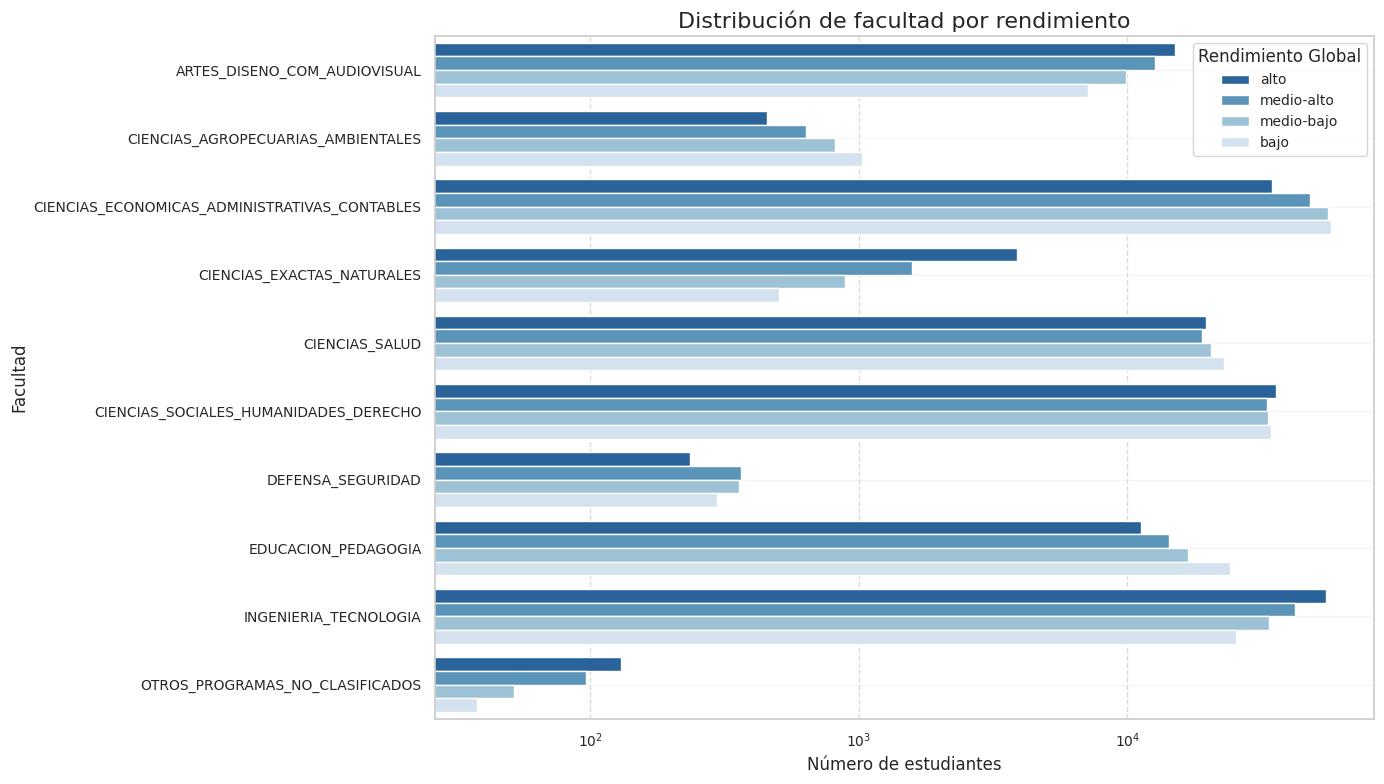

In [255]:
grouped = train_dataset.groupby(
    ['FACULTAD', 'RENDIMIENTO_GLOBAL'],
    observed=False
).size().reset_index(name='count')


# 4. Graficar
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='count',
    y='FACULTAD', # Seaborn respetará el orden de esta variable categórica
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de facultad por rendimiento', fontsize=16)
plt.xlabel('Número de estudiantes', fontsize=12)
plt.ylabel('Facultad', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xscale('log')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.legend(title='Rendimiento Global', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [256]:
train_dataset.drop('ESTU_PRGM_ACADEMICO', inplace=True, axis=1)

##ESTU_HORASSEMANATRABAJA

Debido a la dificultad para efectuar reemplazos sobre los registros que no tienen datos, se decidió eliminarlos, teniendo en cuenta que la cantidad no tiene un impacto significativo en la totalidad del dataset.

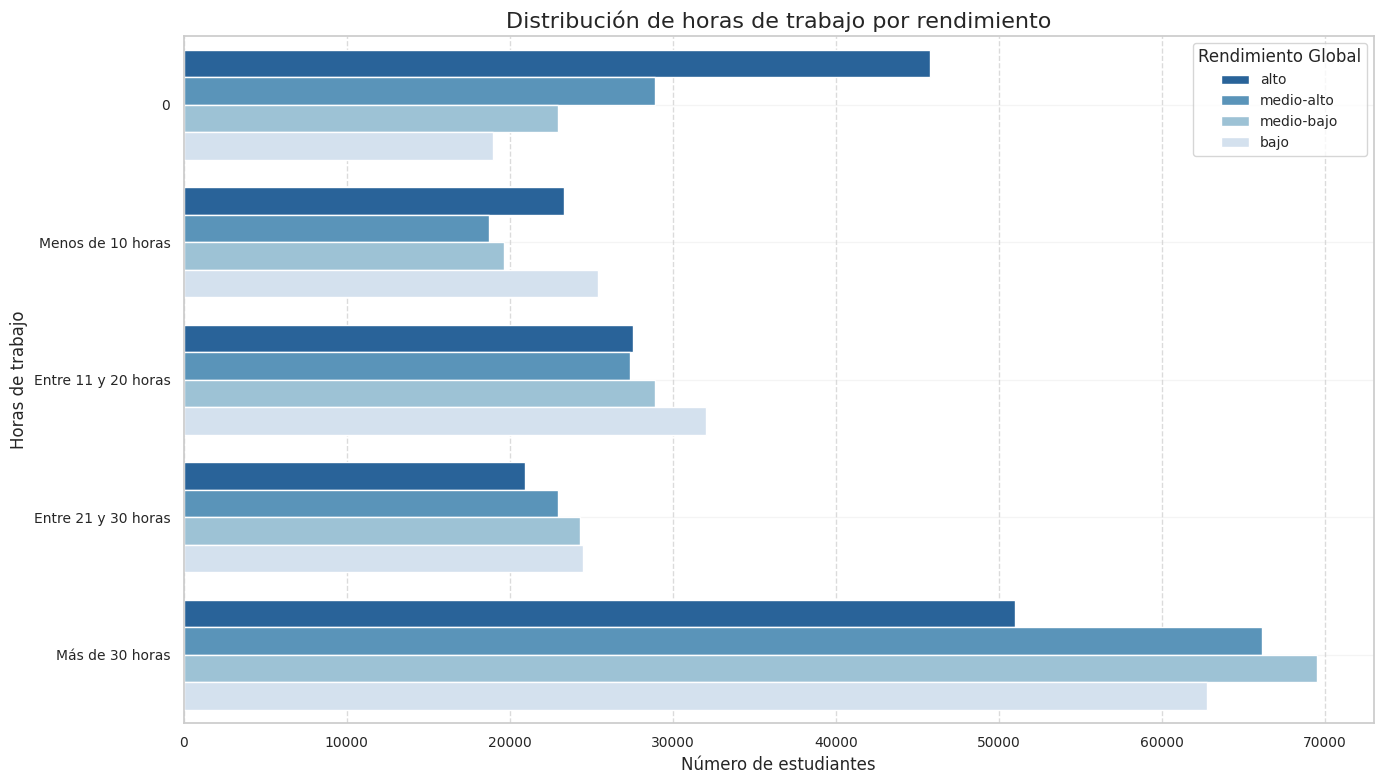

In [257]:
orden_horas = [
    '0',
    'Menos de 10 horas',
    'Entre 11 y 20 horas',
    'Entre 21 y 30 horas',
    'Más de 30 horas'
]

orden_rendimiento = [
    'alto',
    'medio-alto',
    'medio-bajo',
    'bajo'
]

train_dataset['ESTU_HORASSEMANATRABAJA'] = pd.Categorical(
    train_dataset['ESTU_HORASSEMANATRABAJA'],
    categories=orden_horas,
    ordered=True
)

grouped = train_dataset.groupby(
    ['ESTU_HORASSEMANATRABAJA', 'RENDIMIENTO_GLOBAL'],
    observed=False
).size().reset_index(name='count')


# 4. Graficar
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='count',
    y='ESTU_HORASSEMANATRABAJA', # Seaborn respetará el orden de esta variable categórica
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de horas de trabajo por rendimiento', fontsize=16)
plt.xlabel('Número de estudiantes', fontsize=12)
plt.ylabel('Horas de trabajo', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.legend(title='Rendimiento Global', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [258]:
train_dataset.dropna(subset=['ESTU_HORASSEMANATRABAJA'], inplace=True)

##FAMI_TIENEINTERNET

Se comparó con la columna **FAMI_TIENEINTERNET.1** y mediante el método *equal()*, fue posible concluir que ambas columnas son iguales, por lo cual se eliminó la columna **FAMI_TIENEINTERNET.1**. Adicionalmente, los datos faltantes se imputaron como si no tuviesen internet.

In [259]:
train_dataset['FAMI_TIENEINTERNET'].equals(train_dataset['FAMI_TIENEINTERNET.1'])

True

In [260]:
train_dataset.drop('FAMI_TIENEINTERNET.1', axis=1, inplace=True)

In [261]:
train_dataset['FAMI_TIENEINTERNET'] = train_dataset['FAMI_TIENEINTERNET'].fillna('No')

<ipython-input-262-84487950cd4d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['FAMI_TIENEINTERNET', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


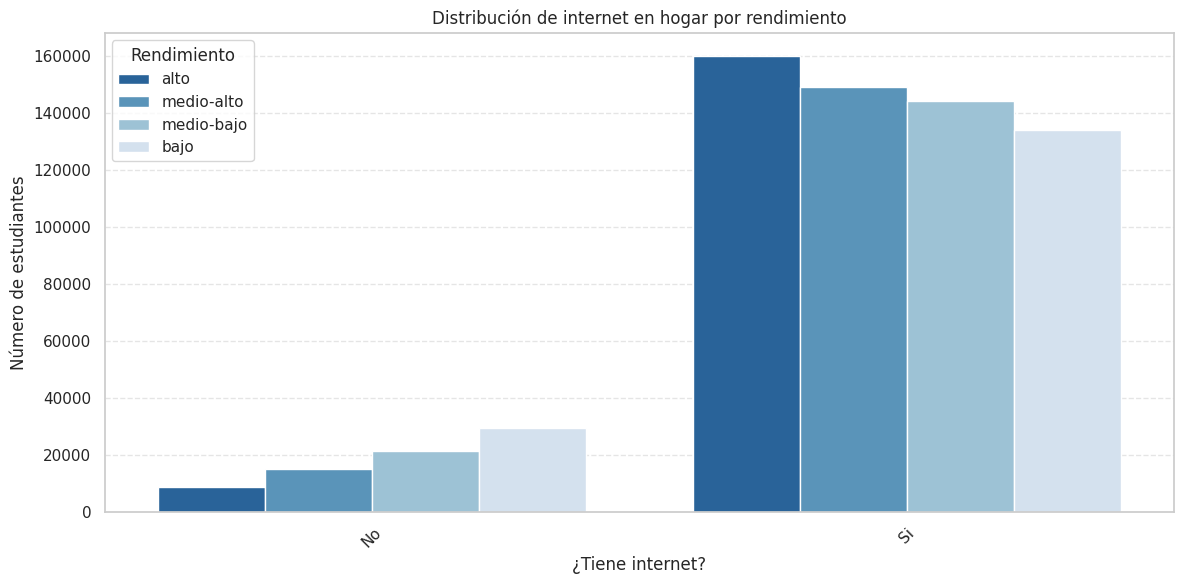

In [262]:
grouped = train_dataset.groupby(['FAMI_TIENEINTERNET', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='FAMI_TIENEINTERNET',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de internet en hogar por rendimiento')
plt.xlabel('¿Tiene internet?')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

##FAMI_TIENELAVADORA

Esta columna comparte una alta similitud con la columna de si en el hogar se tiene internet, por lo cual únicamente se utilizó la columna correspondiente al internet y esta fue eliminada.

<ipython-input-263-eeec6fc3182d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['FAMI_TIENELAVADORA', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


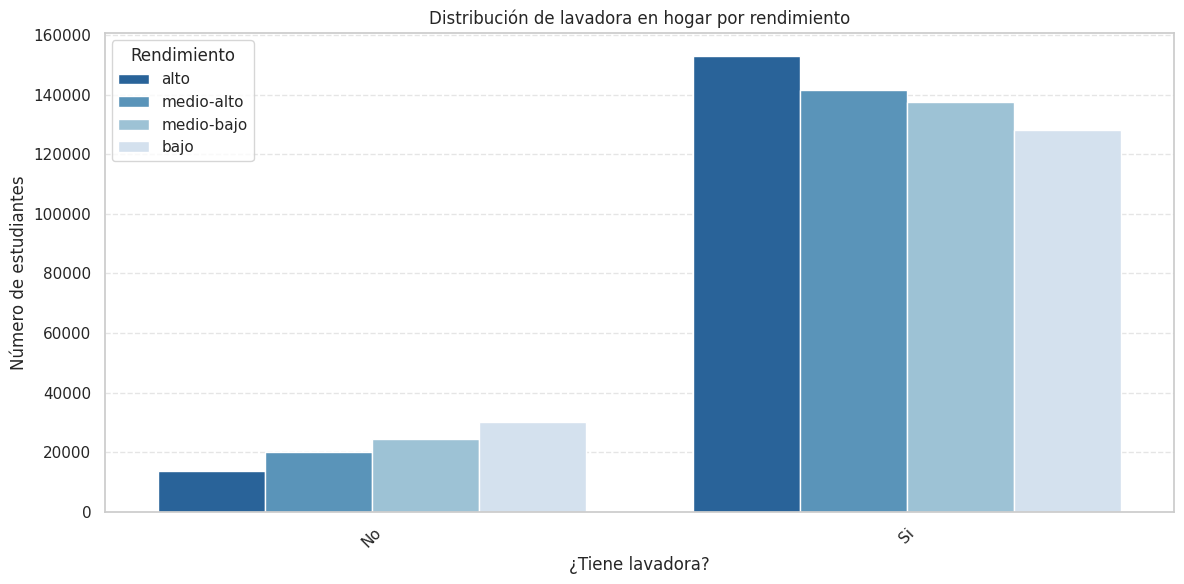

In [263]:
grouped = train_dataset.groupby(['FAMI_TIENELAVADORA', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='FAMI_TIENELAVADORA',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de lavadora en hogar por rendimiento')
plt.xlabel('¿Tiene lavadora?')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

In [264]:
col1 = train_dataset['FAMI_TIENELAVADORA'].astype(str).str.upper()
col2 = train_dataset['FAMI_TIENEINTERNET'].astype(str).str.upper()
comparacion = (col1 == col2)
numero_de_coincidencias = comparacion.sum()
total_filas = len(train_dataset)
porcentaje_de_coincidencia = (numero_de_coincidencias / total_filas) * 100
porcentaje_de_coincidencia

np.float64(82.4839074848521)

In [265]:
train_dataset.drop('FAMI_TIENELAVADORA', axis=1, inplace=True)

##FAMI_TIENECOMPUTADOR

Debido a que esta columna tiene un alta correlación con la columna de **FAMI_TIENEINTERNET**, no seá tenida en cuenta para el análisis posterior.

<ipython-input-266-52a1a9044ed2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['FAMI_TIENECOMPUTADOR', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


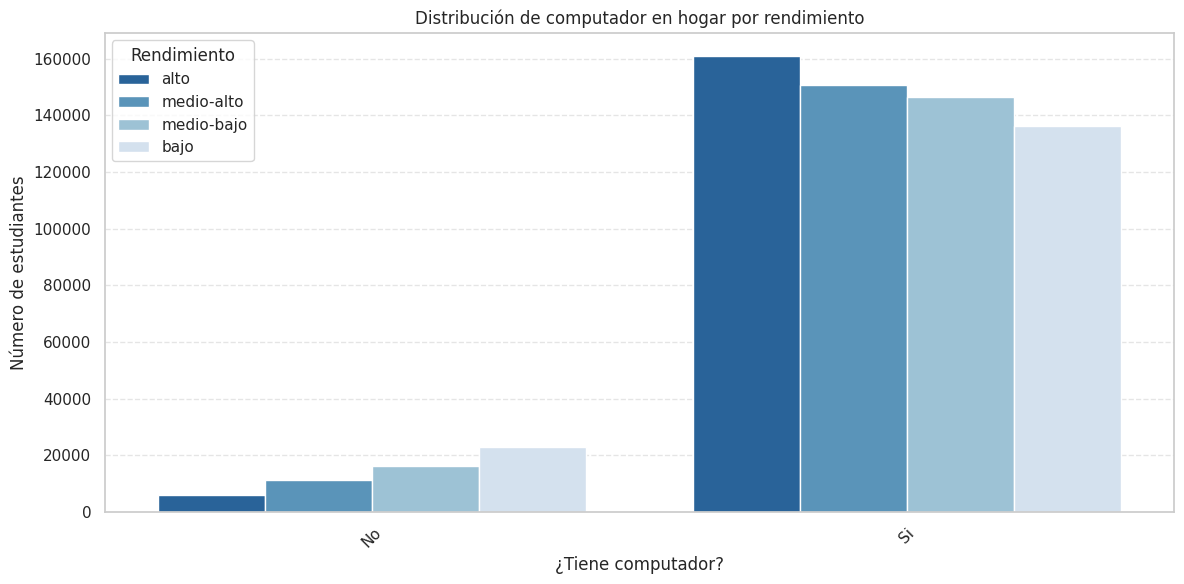

In [266]:
grouped = train_dataset.groupby(['FAMI_TIENECOMPUTADOR', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='FAMI_TIENECOMPUTADOR',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de computador en hogar por rendimiento')
plt.xlabel('¿Tiene computador?')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

In [267]:
col1 = train_dataset['FAMI_TIENECOMPUTADOR'].astype(str).str.upper()
col2 = train_dataset['FAMI_TIENEINTERNET'].astype(str).str.upper()
comparacion = (col1 == col2)
numero_de_coincidencias = comparacion.sum()
total_filas = len(train_dataset)
porcentaje_de_coincidencia = (numero_de_coincidencias / total_filas) * 100
porcentaje_de_coincidencia

np.float64(88.25650690780375)

In [268]:
train_dataset.drop('FAMI_TIENECOMPUTADOR', axis=1, inplace=True)

##FAMI_TIENEAUTOMOVIL

Se imputaron los valores faltantes por 'No' para evitar eliminar la columna totalmente.

In [269]:
train_dataset['FAMI_TIENEAUTOMOVIL'] = train_dataset['FAMI_TIENEAUTOMOVIL'].fillna('No')

<ipython-input-270-bb6b9323f144>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['FAMI_TIENEAUTOMOVIL', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


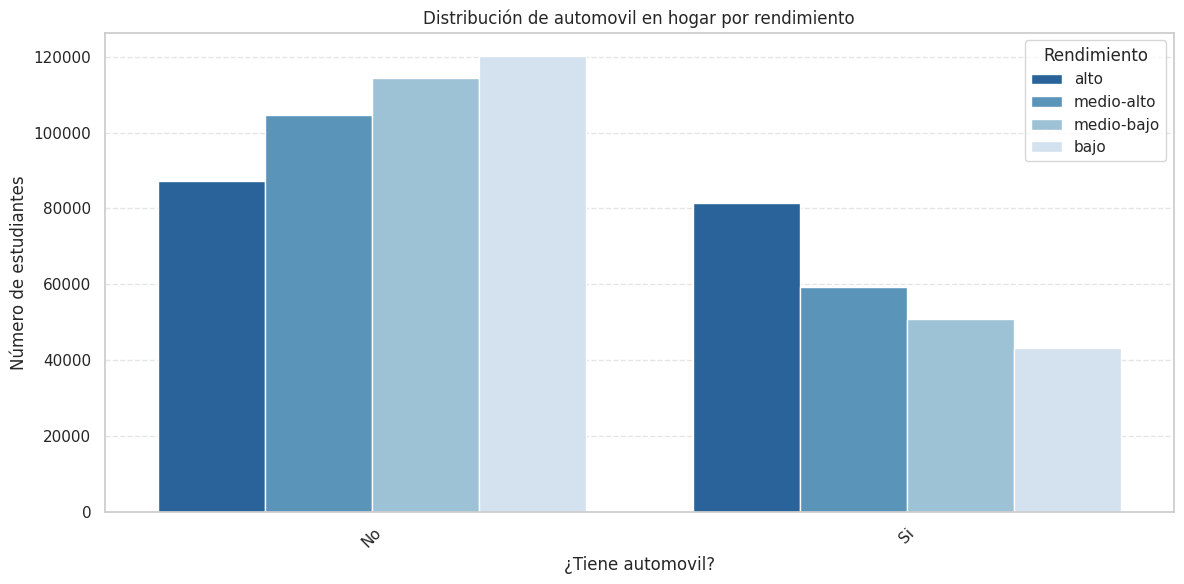

In [270]:
grouped = train_dataset.groupby(['FAMI_TIENEAUTOMOVIL', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='FAMI_TIENEAUTOMOVIL',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de automovil en hogar por rendimiento')
plt.xlabel('¿Tiene automovil?')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

##FAMI_EDUCACIONPADRE

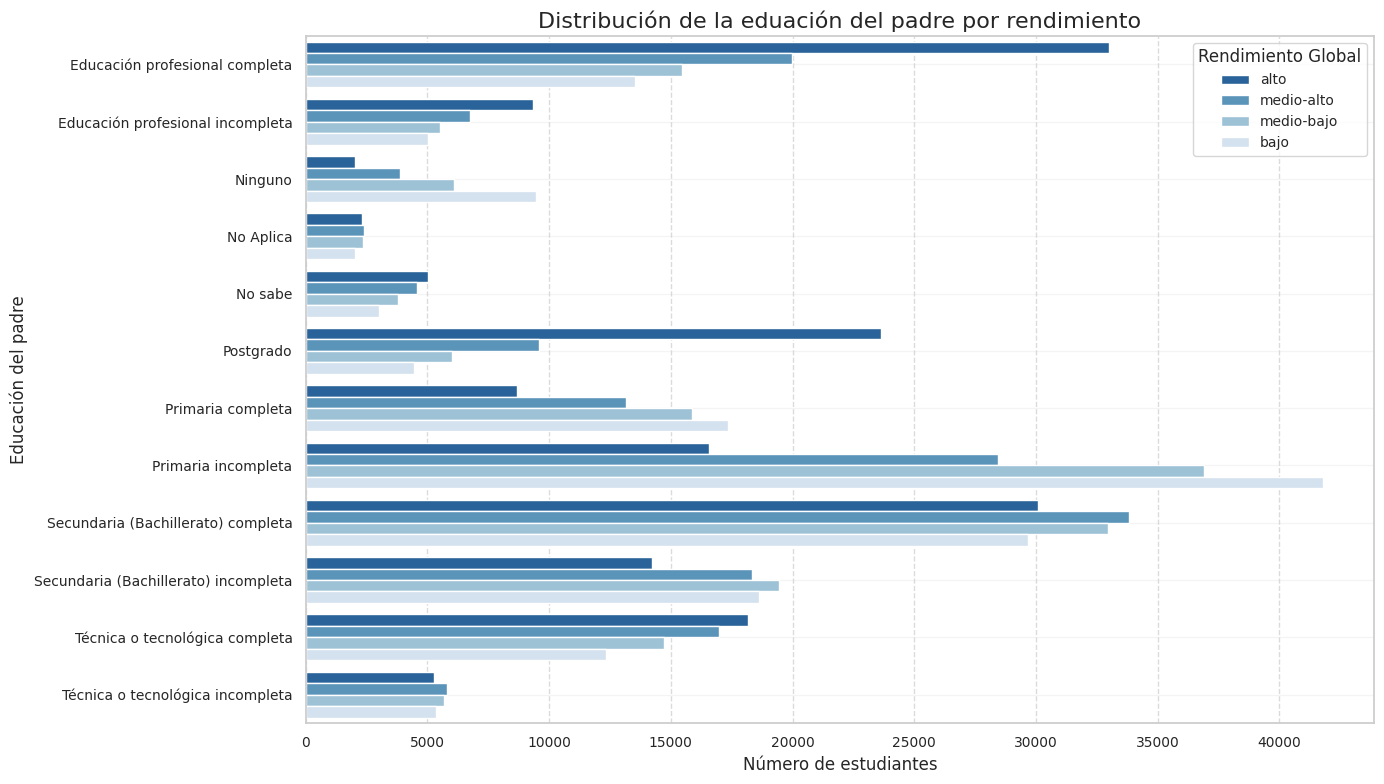

In [271]:
grouped = train_dataset.groupby(
    ['FAMI_EDUCACIONPADRE', 'RENDIMIENTO_GLOBAL'],
    observed=False
).size().reset_index(name='count')


# 4. Graficar
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='count',
    y='FAMI_EDUCACIONPADRE', # Seaborn respetará el orden de esta variable categórica
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de la eduación del padre por rendimiento', fontsize=16)
plt.xlabel('Número de estudiantes', fontsize=12)
plt.ylabel('Educación del padre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.legend(title='Rendimiento Global', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [272]:
valores_a_reemplazar = [
    np.nan,
    'No sabe',
    None
]

mapeo_reemplazo_strings = {
    'No sabe': 'No aplica',
}

train_dataset['FAMI_EDUCACIONPADRE'] = train_dataset['FAMI_EDUCACIONPADRE'].replace(mapeo_reemplazo_strings)
train_dataset['FAMI_EDUCACIONPADRE'] = train_dataset['FAMI_EDUCACIONPADRE'].fillna('No aplica')


##FAMI_EDUCACIONMADRE

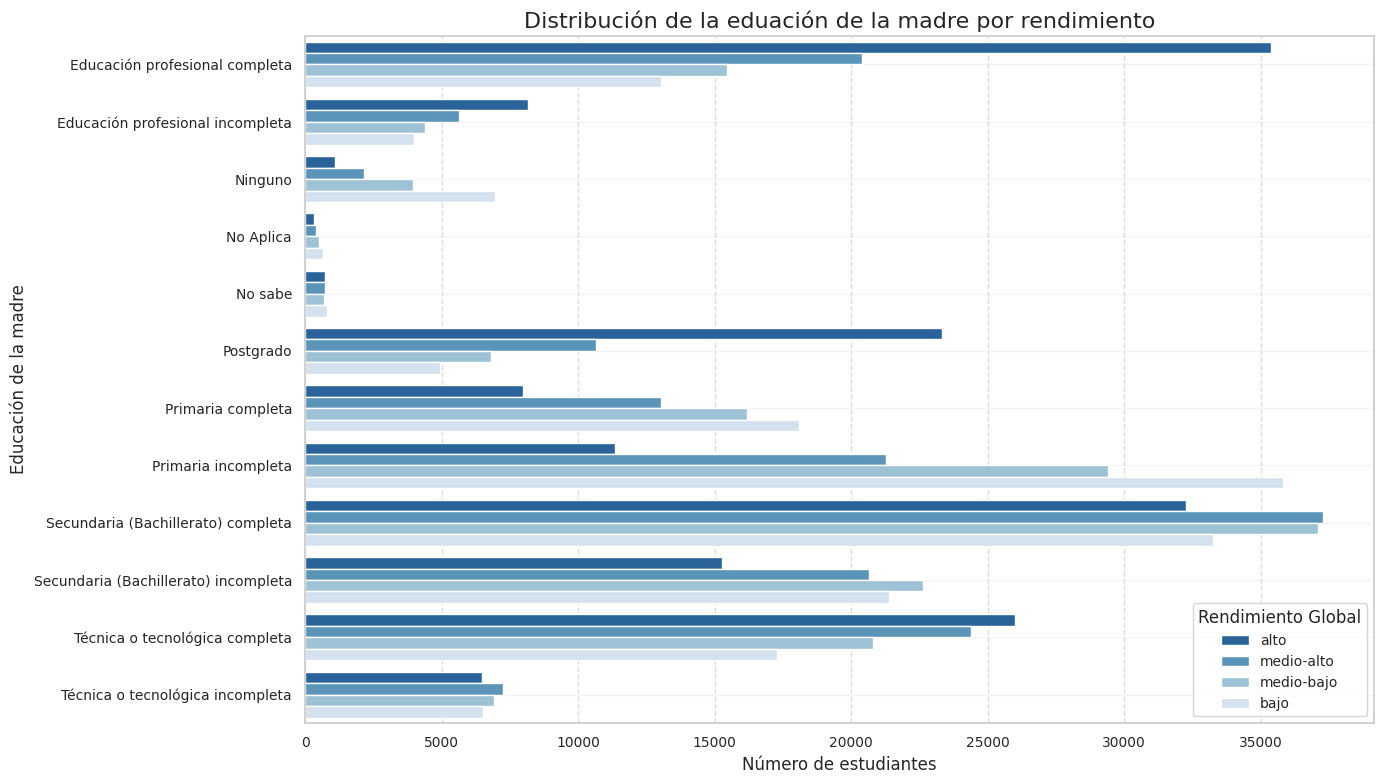

In [273]:
grouped = train_dataset.groupby(
    ['FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL'],
    observed=False
).size().reset_index(name='count')


# 4. Graficar
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='count',
    y='FAMI_EDUCACIONMADRE', # Seaborn respetará el orden de esta variable categórica
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de la eduación de la madre por rendimiento', fontsize=16)
plt.xlabel('Número de estudiantes', fontsize=12)
plt.ylabel('Educación de la madre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.legend(title='Rendimiento Global', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [274]:
train_dataset['FAMI_EDUCACIONMADRE'] = train_dataset['FAMI_EDUCACIONMADRE'].replace(mapeo_reemplazo_strings)
train_dataset['FAMI_EDUCACIONMADRE'] = train_dataset['FAMI_EDUCACIONMADRE'].fillna('No aplica')

##ESTU_PRIVADO_LIBERTAD

<ipython-input-275-d1fe2015bf32>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['ESTU_PRIVADO_LIBERTAD', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


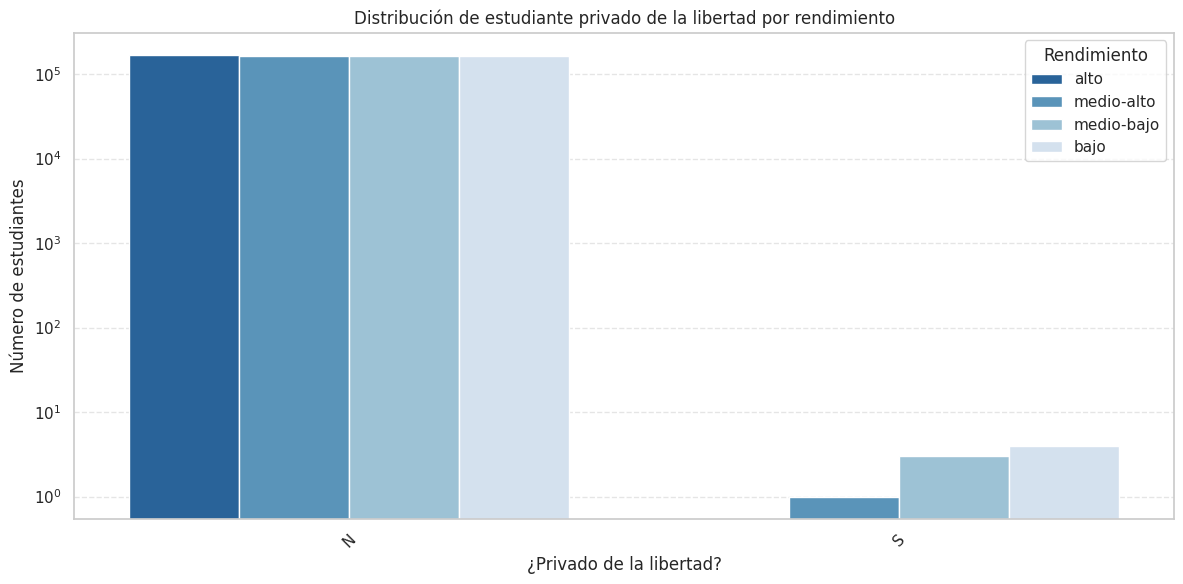

In [275]:
grouped = train_dataset.groupby(['ESTU_PRIVADO_LIBERTAD', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='ESTU_PRIVADO_LIBERTAD',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de estudiante privado de la libertad por rendimiento')
plt.xlabel('¿Privado de la libertad?')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

##ESTU_PAGOMATRICULALPROPIO

<ipython-input-276-cdd729a3ee2e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_dataset.groupby(['ESTU_PAGOMATRICULAPROPIO', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')


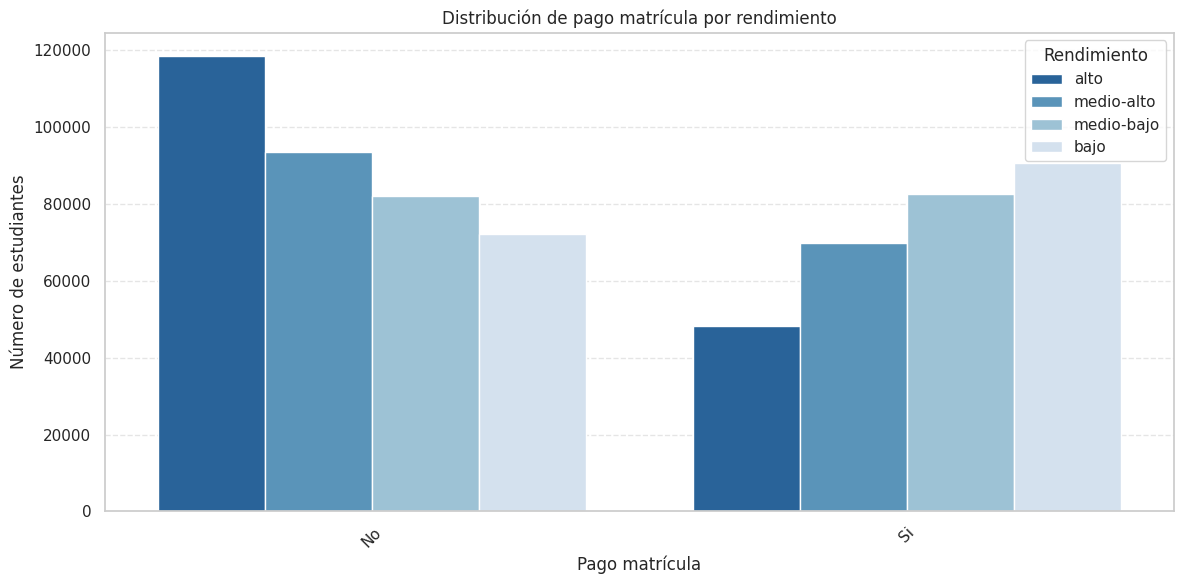

In [276]:
grouped = train_dataset.groupby(['ESTU_PAGOMATRICULAPROPIO', 'RENDIMIENTO_GLOBAL']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=grouped,
    x='ESTU_PAGOMATRICULAPROPIO',
    y='count',
    hue='RENDIMIENTO_GLOBAL',
    palette='Blues_r'
)

plt.title('Distribución de pago matrícula por rendimiento')
plt.xlabel('Pago matrícula')
plt.ylabel('Número de estudiantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Rendimiento')
plt.show()

In [277]:
train_dataset['ESTU_PAGOMATRICULAPROPIO'] = train_dataset['ESTU_PAGOMATRICULAPROPIO'].fillna('No')

In [278]:
train_dataset[train_dataset['ESTU_VALORMATRICULAUNIVERSIDAD'].isna()]

,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,ESTU_PRGM_REGION,FACULTAD


# Codificación

Inicialmente, se codifican las columnas categoricas en one-hot encoding, a excepción de la columna de estrato y de rendimiento global que se codificaron de forma ordinal.

In [279]:
train_dataset.columns

Index(['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD',
       'ESTU_PAGOMATRICULAPROPIO', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL',
       'coef_1', 'coef_2', 'coef_3', 'ESTU_PRGM_REGION', 'FACULTAD'],
      dtype='object')

In [280]:
columnas_codificar = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
        'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENEAUTOMOVIL',
        'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_EDUCACIONMADRE',
        'ESTU_PRGM_REGION', 'FACULTAD']

In [281]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [282]:
datos_para_codificar = train_dataset[columnas_codificar]
datos_codificados_array = encoder.fit_transform(datos_para_codificar)

In [283]:
datos_codificados_array.shape

(661643, 62)

In [284]:
nombres_nuevas_columnas = encoder.get_feature_names_out(input_features=columnas_codificar)
nombres_nuevas_columnas

array(['ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones',
       'ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones',
       'ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones',
       'ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones',
       'ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón',
       'ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil',
       'ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones',
       'ESTU_VALORMATRICULAUNIVERSIDAD_No aplica',
       'ESTU_VALORMATRICULAUNIVERSIDAD_No pagó matrícula',
       'ESTU_HORASSEMANATRABAJA_0',
       'ESTU_HORASSEMANATRABAJA_Entre 11 y 20 horas',
       'ESTU_HORASSEMANATRABAJA_Entre 21 y 30 horas',
       'ESTU_HORASSEMANATRABAJA_Menos de 10 horas',
       'ESTU_HORASSEMANATRABAJA_Más de 30 horas', 'FAMI_TIENEINTERNET_No',
       'FAMI_TIENEINTERNET_Si',
       'FAMI_EDUCACIONPADRE_Educación profesional completa',
       '

In [285]:
df_codificado = df_codificado = pd.DataFrame(
    datos_codificados_array,
    columns=nombres_nuevas_columnas,
    index=train_dataset.index
)
df_codificado

,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_No aplica,ESTU_VALORMATRICULAUNIVERSIDAD_No pagó matrícula,ESTU_HORASSEMANATRABAJA_0,...,FACULTAD_ARTES_DISENO_COM_AUDIOVISUAL,FACULTAD_CIENCIAS_AGROPECUARIAS_AMBIENTALES,FACULTAD_CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES,FACULTAD_CIENCIAS_EXACTAS_NATURALES,FACULTAD_CIENCIAS_SALUD,FACULTAD_CIENCIAS_SOCIALES_HUMANIDADES_DERECHO,FACULTAD_DEFENSA_SEGURIDAD,FACULTAD_EDUCACION_PEDAGOGIA,FACULTAD_INGENIERIA_TECNOLOGIA,FACULTAD_OTROS_PROGRAMAS_NO_CLASIFICADOS
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
692496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [286]:
train_dataset.drop(columns=columnas_codificar, inplace=True)
train_dataset = pd.concat([train_dataset, df_codificado], axis=1)
train_dataset

,FAMI_ESTRATOVIVIENDA,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,...,FACULTAD_ARTES_DISENO_COM_AUDIOVISUAL,FACULTAD_CIENCIAS_AGROPECUARIAS_AMBIENTALES,FACULTAD_CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES,FACULTAD_CIENCIAS_EXACTAS_NATURALES,FACULTAD_CIENCIAS_SALUD,FACULTAD_CIENCIAS_SOCIALES_HUMANIDADES_DERECHO,FACULTAD_DEFENSA_SEGURIDAD,FACULTAD_EDUCACION_PEDAGOGIA,FACULTAD_INGENIERIA_TECNOLOGIA,FACULTAD_OTROS_PROGRAMAS_NO_CLASIFICADOS
0,Estrato 3,medio-alto,0.322,0.208,0.310,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Estrato 3,bajo,0.311,0.215,0.292,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Estrato 3,bajo,0.297,0.214,0.305,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Estrato 4,alto,0.485,0.172,0.252,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Estrato 3,medio-bajo,0.316,0.232,0.285,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,Estrato 2,medio-alto,0.237,0.271,0.271,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
692496,Estrato 3,bajo,0.314,0.240,0.278,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692497,Estrato 3,medio-bajo,0.286,0.240,0.314,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692498,Estrato 1,bajo,0.132,0.426,0.261,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [290]:
orden_estratos = ['Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']

In [291]:
ord_encoder = OrdinalEncoder(
    categories=[orden_estratos],
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)

In [292]:
train_dataset['FAMI_ESTRATOVIVIENDA'] = encoder.fit_transform(train_dataset[['FAMI_ESTRATOVIVIENDA']])

In [293]:
train_dataset

,FAMI_ESTRATOVIVIENDA,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,...,FACULTAD_ARTES_DISENO_COM_AUDIOVISUAL,FACULTAD_CIENCIAS_AGROPECUARIAS_AMBIENTALES,FACULTAD_CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES,FACULTAD_CIENCIAS_EXACTAS_NATURALES,FACULTAD_CIENCIAS_SALUD,FACULTAD_CIENCIAS_SOCIALES_HUMANIDADES_DERECHO,FACULTAD_DEFENSA_SEGURIDAD,FACULTAD_EDUCACION_PEDAGOGIA,FACULTAD_INGENIERIA_TECNOLOGIA,FACULTAD_OTROS_PROGRAMAS_NO_CLASIFICADOS
0,3.0,medio-alto,0.322,0.208,0.310,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3.0,bajo,0.311,0.215,0.292,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,bajo,0.297,0.214,0.305,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,alto,0.485,0.172,0.252,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,medio-bajo,0.316,0.232,0.285,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,2.0,medio-alto,0.237,0.271,0.271,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
692496,3.0,bajo,0.314,0.240,0.278,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692497,3.0,medio-bajo,0.286,0.240,0.314,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692498,1.0,bajo,0.132,0.426,0.261,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [294]:
columna_extraida = train_dataset.pop('RENDIMIENTO_GLOBAL')
train_dataset['RENDIMIENTO_GLOBAL'] = columna_extraida
train_dataset

,FAMI_ESTRATOVIVIENDA,coef_1,coef_2,coef_3,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,...,FACULTAD_CIENCIAS_AGROPECUARIAS_AMBIENTALES,FACULTAD_CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES,FACULTAD_CIENCIAS_EXACTAS_NATURALES,FACULTAD_CIENCIAS_SALUD,FACULTAD_CIENCIAS_SOCIALES_HUMANIDADES_DERECHO,FACULTAD_DEFENSA_SEGURIDAD,FACULTAD_EDUCACION_PEDAGOGIA,FACULTAD_INGENIERIA_TECNOLOGIA,FACULTAD_OTROS_PROGRAMAS_NO_CLASIFICADOS,RENDIMIENTO_GLOBAL
0,3.0,0.322,0.208,0.310,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,medio-alto
1,3.0,0.311,0.215,0.292,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,bajo
2,3.0,0.297,0.214,0.305,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bajo
3,4.0,0.485,0.172,0.252,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,alto
4,3.0,0.316,0.232,0.285,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,medio-bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,2.0,0.237,0.271,0.271,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,medio-alto
692496,3.0,0.314,0.240,0.278,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,bajo
692497,3.0,0.286,0.240,0.314,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,medio-bajo
692498,1.0,0.132,0.426,0.261,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,bajo


In [ ]:
orden_rendimiento = [
    'alto',
    'medio-alto',
    'medio-bajo',
    'bajo'
]


In [296]:
ord_encoder_1 = OrdinalEncoder(
    categories=[orden_rendimiento],
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)

In [297]:
train_dataset['RENDIMIENTO_GLOBAL'] = ord_encoder_1.fit_transform(train_dataset[['RENDIMIENTO_GLOBAL']])
train_dataset

,FAMI_ESTRATOVIVIENDA,coef_1,coef_2,coef_3,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,...,FACULTAD_CIENCIAS_AGROPECUARIAS_AMBIENTALES,FACULTAD_CIENCIAS_ECONOMICAS_ADMINISTRATIVAS_CONTABLES,FACULTAD_CIENCIAS_EXACTAS_NATURALES,FACULTAD_CIENCIAS_SALUD,FACULTAD_CIENCIAS_SOCIALES_HUMANIDADES_DERECHO,FACULTAD_DEFENSA_SEGURIDAD,FACULTAD_EDUCACION_PEDAGOGIA,FACULTAD_INGENIERIA_TECNOLOGIA,FACULTAD_OTROS_PROGRAMAS_NO_CLASIFICADOS,RENDIMIENTO_GLOBAL
0,3.0,0.322,0.208,0.310,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,0.311,0.215,0.292,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
2,3.0,0.297,0.214,0.305,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,4.0,0.485,0.172,0.252,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.316,0.232,0.285,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,2.0,0.237,0.271,0.271,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
692496,3.0,0.314,0.240,0.278,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
692497,3.0,0.286,0.240,0.314,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
692498,1.0,0.132,0.426,0.261,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
